<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Problem description and objective:

## Motivation:

Ads industry heavily relies on data science to determine, 

1. which ad to display, 
2. how much to spend on each ad campaign, 
3. ways to optimize the ad text, 
4. position of the ad, and etc. 

Many companies spend millions of dollars on advertisements, however, they used to spend little to none on data science targeting ad optimizations until recently. Currently, after realizing the importance of optimizing ads, companies are investing more time and resources on data science. 

Two major companies with Ads as one of their main revenue streams are Google and Facebook. They make use of the huge amount data from ads (TBs to PBs) to extract useful information using machine learning (or deep learning) techniques and optimize them to maximize their earnings.

## Data description:

XYZ is a food delivery company and it relies on online ads to get customers such as those we see on Google or Facebook. Currently they are running 40 different ad campaigns. The data contains the following information.

<b>Parameters:</b><br>
<b>date :</b> All data are aggregated by date <br>
<b>shown :</b> Number of ads shown on a given day all over the web. Impressions are free. That is, companies pay only if a user clicks on the ad, not to show it <br>
<b>clicked (frequency):</b> Number of clicks on the ads. This is what companies pay for. By clicking on
the ad, the user is brought to the site <br>
<b>converted :</b> Number of conversions on the site coming from ads. To be counted, a conversion has to happen on the same day as the ad click.<br>
<b>avg_cost_per_click :</b> On an average, how much it cost each of those clicks <br>
<b>total_revenue :</b> How much revenue came from the conversions <br>
<b>ad :</b> We have several different ad groups. This shows which ad group we are considering

## Objective:

Study the performance of 40 ad campaigns and answer the following questions to make a better decision:
1. Identify 5 best ad groups. Justify the metric chosen. Explain the pros and cons of the metric.
2. For each group predict, how many ads will be shown on a particular date (let's say Dec 15) by assuming that each group follows its trend.
3. Cluster ads into 3 groups:<br>
    a. avg_cost_per_click is going up<br>
    b. avg_cost_per_click is constant<br>
    c. avg_cost_per_click is going down



## List of Metrics:

The following are the 5 important metrics that are used in ads industry to measure its performance

<b> Click-through rate (CTR): </b> <br>
    It symbolizes the effectiveness as well as relevance of the ad displayed. A low click-through rate is a red sign to the campaign. It means the ad needs improvements interms of words used (creativeness), the way it is displayed, and much more. CTR is one of the most important metrics used to determine the quality of an ad.
    
$$CTR = \frac{{{\rm{ads\_clicked}}}}{{{\rm{ads\_shown}}}}$$

<b> Conversion rate (CR): </b> <br>
    Another important metric in determining the quality of an ad. It is important to have a high CR as we don't want to pay for the clicks that are not generating any revenue. Low conversion rate implies that we are pouring lot of money down the drain and the ad needs to be either improved or stopped.
    
$$CR = \frac{{{\rm{ads\_converted}}}}{{{\rm{ads\_clicked}}}}$$

<b> Cost-per-conversion (CPC): </b><br>
        CPC needs to be as low as possible, meaning, we need to spend less $$ for the converted ads in average. Here we are not taking into account the revenue generated from the purchase. This parameter allows us to view the campaign as win or lose because if we are spending more to gain a customer than their value to the business then the campaign is not worth continuing.
        
$$CPC = \frac{{{\rm{total\_amount\_spent}}}}{{{\rm{ads\_converted}}}}$$

<b> Wasted Spend (WS): </b><br>
        How much money is wasted on the clicks that are not converted to purchases. 
        
        
$$WS = (clicked - converted) * avg\_cost\_per\_click $$

<b> Revenue per CPC (RCPC): </b><br>
        This tells us how much we are making per $ spent on ads. This is important because we might have large conversion rate and low cost-per-conversion for an campaign but what is point when we are making less dollars per click than other campaigns?
        
$$RCPC = \frac{{{\rm{Total\_revenue}}}}{{{\rm{ads\_clicked}}}}$$

## Qualify factor:

All the 5 metrics listed above are useful for determining the success of a campaign but we cannot have multiple metrics to make a decision. Hence, in this section, lets construct a metric that combines all the above, with appropriate weights, into a single metric called quality factor.

Things to consider: <br>
Make sure all the individual metrics are normalized before combining and imply success/failure in the same way from its value. For example, <br>
CTR - Higher the value higher the success rate <br>
CR - Higher the value higher the success rate <br>
CPC - Lower the value higher the success rate <br>
WS - Lower the value higher the success rate <br>
RCPC - Higher the value higher the success rate <br>

From the above definition, it is clear that all the parameters can not be combined in the same way as their values imply success/failure in the opposite manner. Either CPC and WS should be inverted to combine with other 3 parameters or vice versa.

To get the quality factor (QF), we can combine all the 5 parameters linearly with corresponding weights as coefficients.

$$QF = {w_1}CTR + {w_2}CR + {w_3}CP{C^{ - 1}} + {w_4}W{S^{ - 1}} + {w_5}RCPC$$

where ${w_1}$, ${w_2}$, ${w_3}$, ${w_4}$, and ${w_5}$ are the weights assigned to CTR, CR, CPC, WS, and RCPC respectively.

It will take a separate study just to find the desired value for the weights. It also requires what metric the particular business gives importance to. So, for this analysis, let's assume equal weights to all 5 metrics. The previous equation becomes,
$$QF = \frac{{CTR + CR + CP{C^{ - 1}} + W{S^{ - 1}} + RCPC}}{5}$$

In general the next step would be is to identify the critical value for success. However, in this study we focus on identifying the top 5 campaigns by rank.

## Pros and cons of the metric:

# Data Exploration:

In [96]:
% matplotlib inline

import pandas as pd
import math as m
from bdateutil import isbday
import holidays
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import numpy as np
import calendar
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler as MM

warnings.simplefilter('ignore')
US_holidays = holidays.US()

In [9]:
df = pd.read_csv( "./data/ad_table.csv" )
df.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [6]:
# Dimension of the dataframe:
df.shape

(2115, 7)

The dataset has 2115 rows and 7 columns

<b> Unique ad groups in the dataset: </b>

In [3]:
df['ad'].unique()

array(['ad_group_1', 'ad_group_2', 'ad_group_3', 'ad_group_4',
       'ad_group_5', 'ad_group_6', 'ad_group_7', 'ad_group_8',
       'ad_group_9', 'ad_group_10', 'ad_group_11', 'ad_group_12',
       'ad_group_13', 'ad_group_14', 'ad_group_15', 'ad_group_16',
       'ad_group_17', 'ad_group_18', 'ad_group_19', 'ad_group_20',
       'ad_group_21', 'ad_group_22', 'ad_group_23', 'ad_group_24',
       'ad_group_25', 'ad_group_26', 'ad_group_27', 'ad_group_28',
       'ad_group_29', 'ad_group_30', 'ad_group_31', 'ad_group_32',
       'ad_group_33', 'ad_group_34', 'ad_group_35', 'ad_group_36',
       'ad_group_37', 'ad_group_38', 'ad_group_39', 'ad_group_40'], dtype=object)

## Check for missing values

In [8]:
print("Percentage of available data for each parameter:")
print( df.count() * 100 / len(df) )

Percentage of available data for each parameter:
date                  100.0
shown                 100.0
clicked               100.0
converted             100.0
avg_cost_per_click    100.0
total_revenue         100.0
ad                    100.0
dtype: float64


No missing data. We have 100% data on all the columns. However we still need to investigate for erroneous values in the data

## Check for data integrity

In [10]:
# Date:
try:
    df['date'] = pd.to_datetime(df['date'])
except Exception as e:
    print(e)
    print("Please check for data points in the 'date' column that are in unacceptable format")

If the date is in any unacceptable format then the above step would fail. One more step in validating datetime is to plot any other parameter across the dates.

In [12]:
# Type setting on each column:
def typeset(data, dtype):
    try:
        data = data.astype(dtype)
    except Exception as e:
        print("Exception on columns %s: %s" %(data.name, e))
    return data
    # This step will print the exception triggered if the data in the corresponding column 
    # cannot be forced to a particular format due to some data values in unacceptable formats

# List of columns and expected datatypes:
cols = [('shown', int), ('clicked', int), ('converted', int), 
        ('avg_cost_per_click', float), ('total_revenue', float)]

for col, dtype in cols:
    df[col] = typeset(df[col], dtype)

Each column is checked for erroneous data (different format) by forcing an appropriate datatype and look for exceptions. Please note that this is the first step in checking data integrity, not the final step. We also need check for the data range, valid values, outliers, and etc. and make sure that the data is sensible. For instance, when all the values in the avg_cost_per_click column is roughly 1 dollar and if we find values in the range of 100s of dollars then these are considered to be erroneous values or outliers and replaced with a suitable methods.

## Outliers and distribution of the data

Check for outliers in each column through visualization techniques

### Shown:

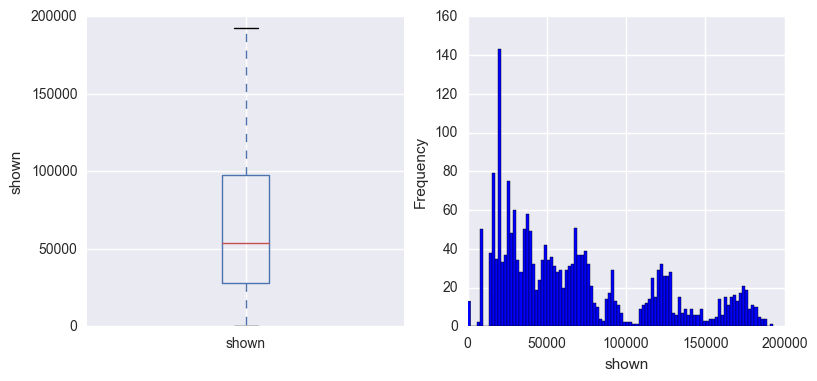

In [6]:
# Shown:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
df.shown.plot.box(ax = axes[0])
df.shown.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("shown")
axes[1].set_xlabel("shown")

For all the groups combined, the are no outliers in the 'shown' column and the values seems sensible; that is 200000 is practically possible.

### Clicked:

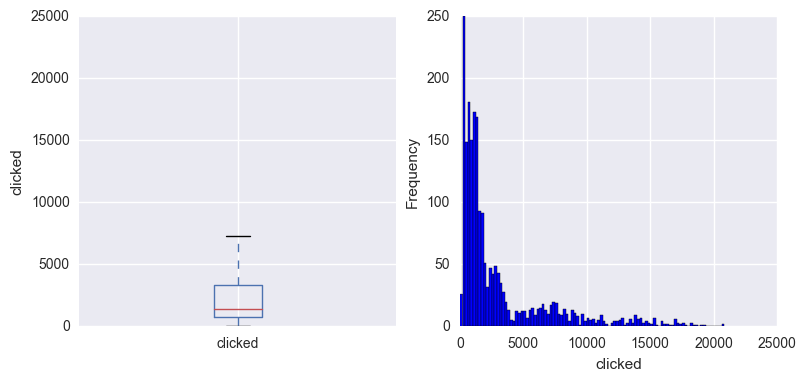

In [17]:
# Clicked:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df.clicked.plot.box(ax = axes[0])
df.clicked.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("clicked")
axes[1].set_xlabel("clicked")

There are outliers in the 'clicked' column ( refer to whiskers in the boxplot(left) ). The maximum value is around 21000 which is much less than 'shown' column's maximum. Although it may seem good, we still need to check that 'clicked' <= 'shown'. It is impossible to have clicks more than the ads displayed.

In [13]:
df[ df['clicked'] > df['shown'] ]

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad


Great! The 'clicked' columns looks good. There are no data violating the condition 'clicked' <= 'shown'

### Converted:

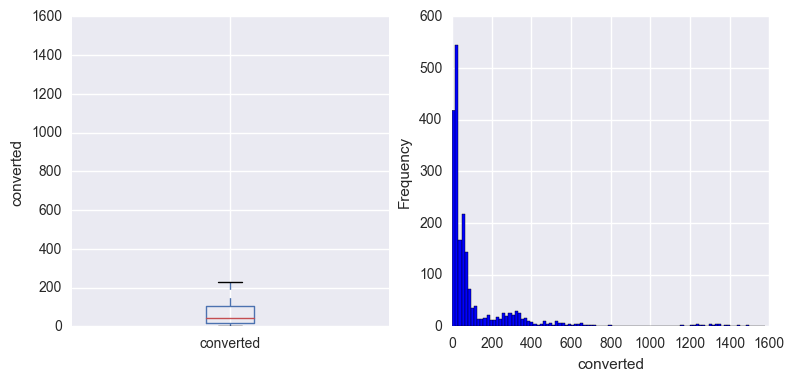

In [18]:
# converted:
fig, axes = plt.subplots(1, 2, figsize = (9, 4))
df.converted.plot.box(ax = axes[0])
df.converted.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("converted")
axes[1].set_xlabel("converted")

There are outliers in the 'converted' column as well. However, that could be related to a specific group(s). Therefore, it requires further investigation. 

The value should be less compared to the 'clicked' column. Lets check that.

In [16]:
df[df['converted'] > df['clicked']]

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad


Excellent! There are no data violating the condition 'converted' < 'clicked'.

### Average cost per click:

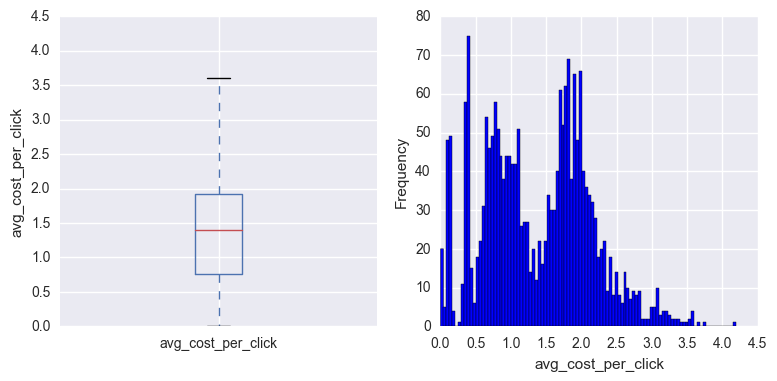

In [20]:
# avg_cost_per_click:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df.avg_cost_per_click.plot.box(ax = axes[0])
df.avg_cost_per_click.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("avg_cost_per_click")
axes[1].set_xlabel("avg_cost_per_click")

Nice! The values makes sense. There may be few outliers. Although the maximum value is not outrageously high, the values over $3.5 may need further investigation which will be carried out in the follwing sections.

### Total Revenue:

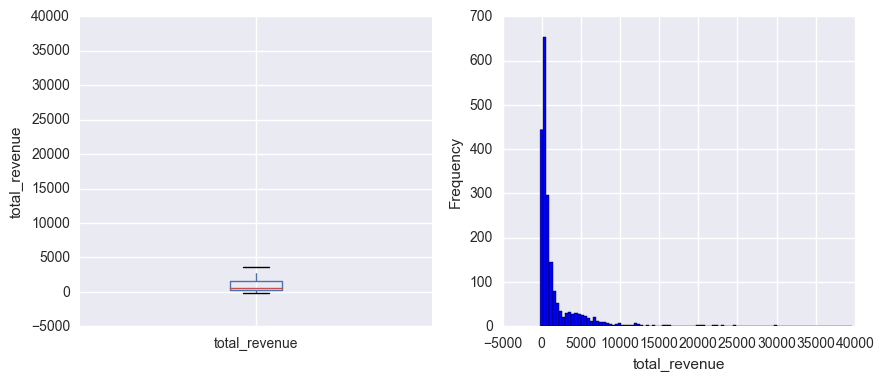

In [23]:
# total_revenue:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.total_revenue.plot.box(ax = axes[0])
df.total_revenue.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("total_revenue")
axes[1].set_xlabel("total_revenue")

Possibly, there are lot of outliers in the data. It could related to a specific ad groups as discussed before and requires indepth study. 

Does the 'total_revenue' has negative values? Let's check that.

In [8]:
df[df['total_revenue'] < 0]

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
1186,2015-10-25,50459,1904,97,0.89,-200.15,ad_group_23
1404,2015-11-01,70145,584,15,0.36,-25.09,ad_group_27
1524,2015-11-15,22070,1400,20,1.67,-3.56,ad_group_29
2089,2015-10-28,80270,1151,41,0.96,-92.06,ad_group_40


Is it possible to have negative values for total_revenue? Yes. When the cost spent on advertisements (clicked) is more than the money gained from purchases (converted), then the revenue will be negative. Therefore, the negative values are allowed. 

## Data Sampling:

One more step in understanding the data is to know the amount of samples in each group. Are they equally distributed or one group has more samples than the other? This study will be helpful in data sampling step of modeling. It is important to sample the data that represents the population.

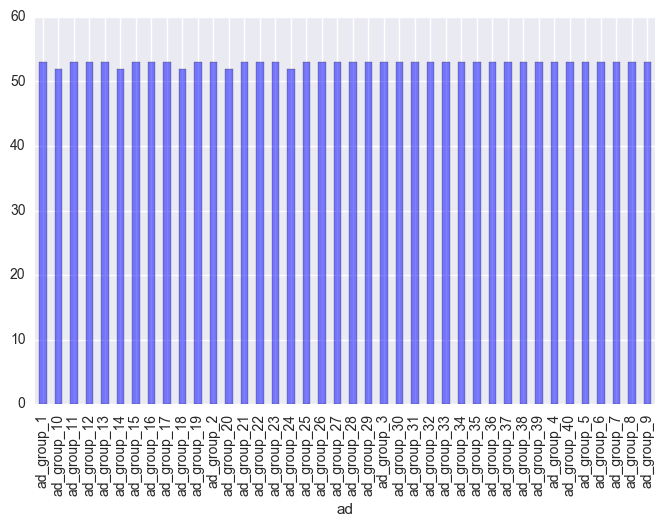

In [28]:
dff = df.groupby('ad')['shown'].count()
dff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

The above bar chart clearly shows that we have almost equal number of data points for each ad group. So we could direct apply random sampling technique (Monte Carlo) to sample data for modeling. 

In case, the data is not uniformly distributed among the different ad groups, then we have to apply stratified sampling technique to pick sample data that represents the actual population. It is important to note that the stratified sampling is only applicable when we have similar dependancies between variables in each group such that the group category can be ignored in modeling.

## Data Engineering - Scatter plot (grid):

It is important to understand the relation between variables. In case of two numerical variables, we can simple use scatter plot. To study the relation between a numerical and a categorical variables, we can use bar chart. To find the relation between 2 categorical variables, stacked column chart can be used. As we have just 1 categorical variable in the dataset, we will not be using stacked column plot. 

### All numerical variables:

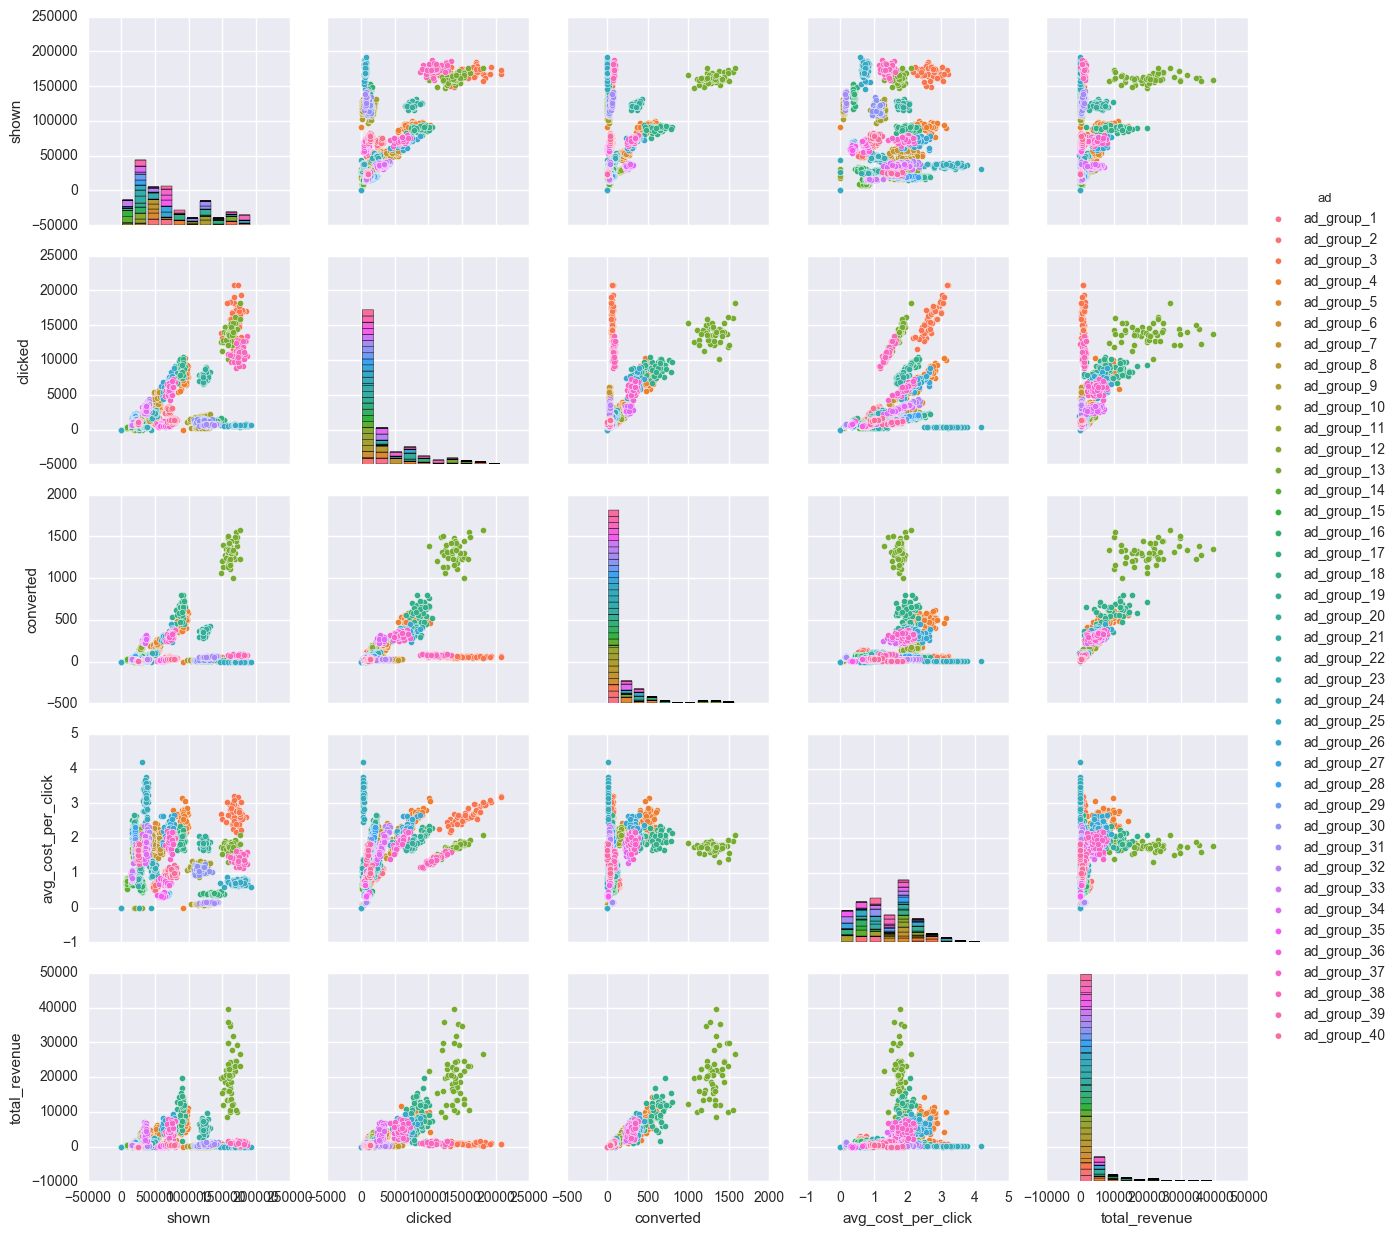

In [30]:
sns.pairplot(df[['shown', 'clicked', 'converted', 'avg_cost_per_click', 
                 'total_revenue', 'ad']], hue = 'ad')

Above pairplot shows no direct correlation between any of the variables in the table when data from all the groups combined are used. However, the plot shows clusters of data that might have linear and non-linear relationships between respective parameters. As we have multiple clusters in each of the above plots, when we segregate the data based on ad group we might discover some relationship between the parameters.

<b> Ad group 1: </b>

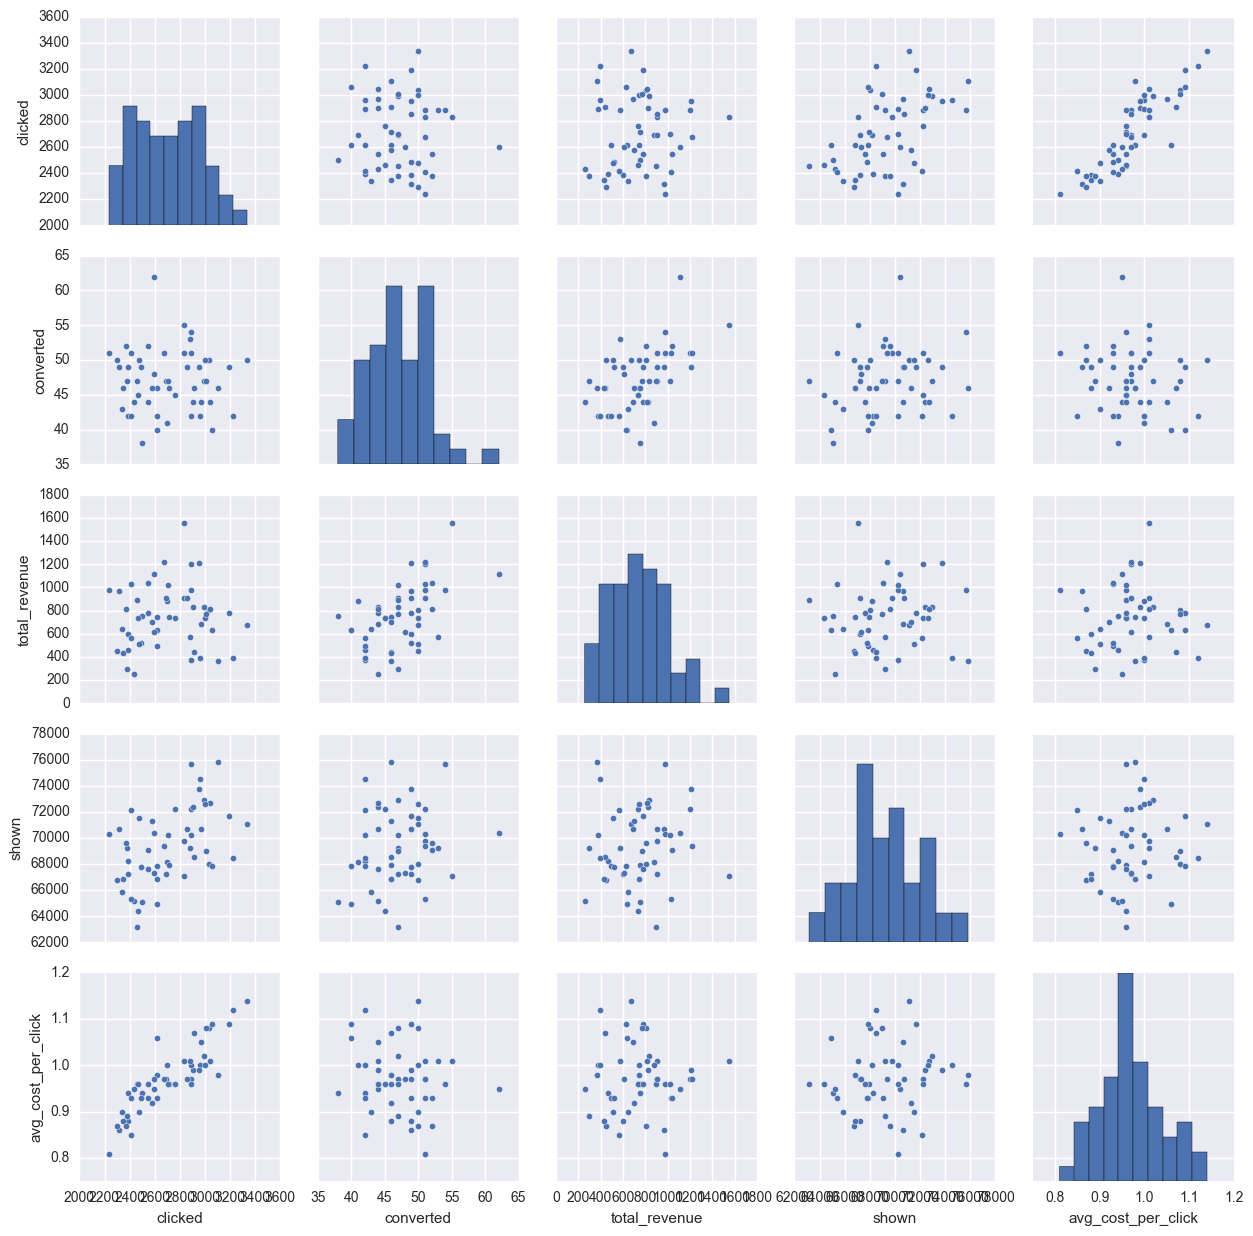

In [32]:
sns.pairplot(df.ix[df['ad'] == 'ad_group_1', {'shown', 'clicked', 'converted', 
                                              'avg_cost_per_click', 'total_revenue'}])

<b> Ad group 5: </b>

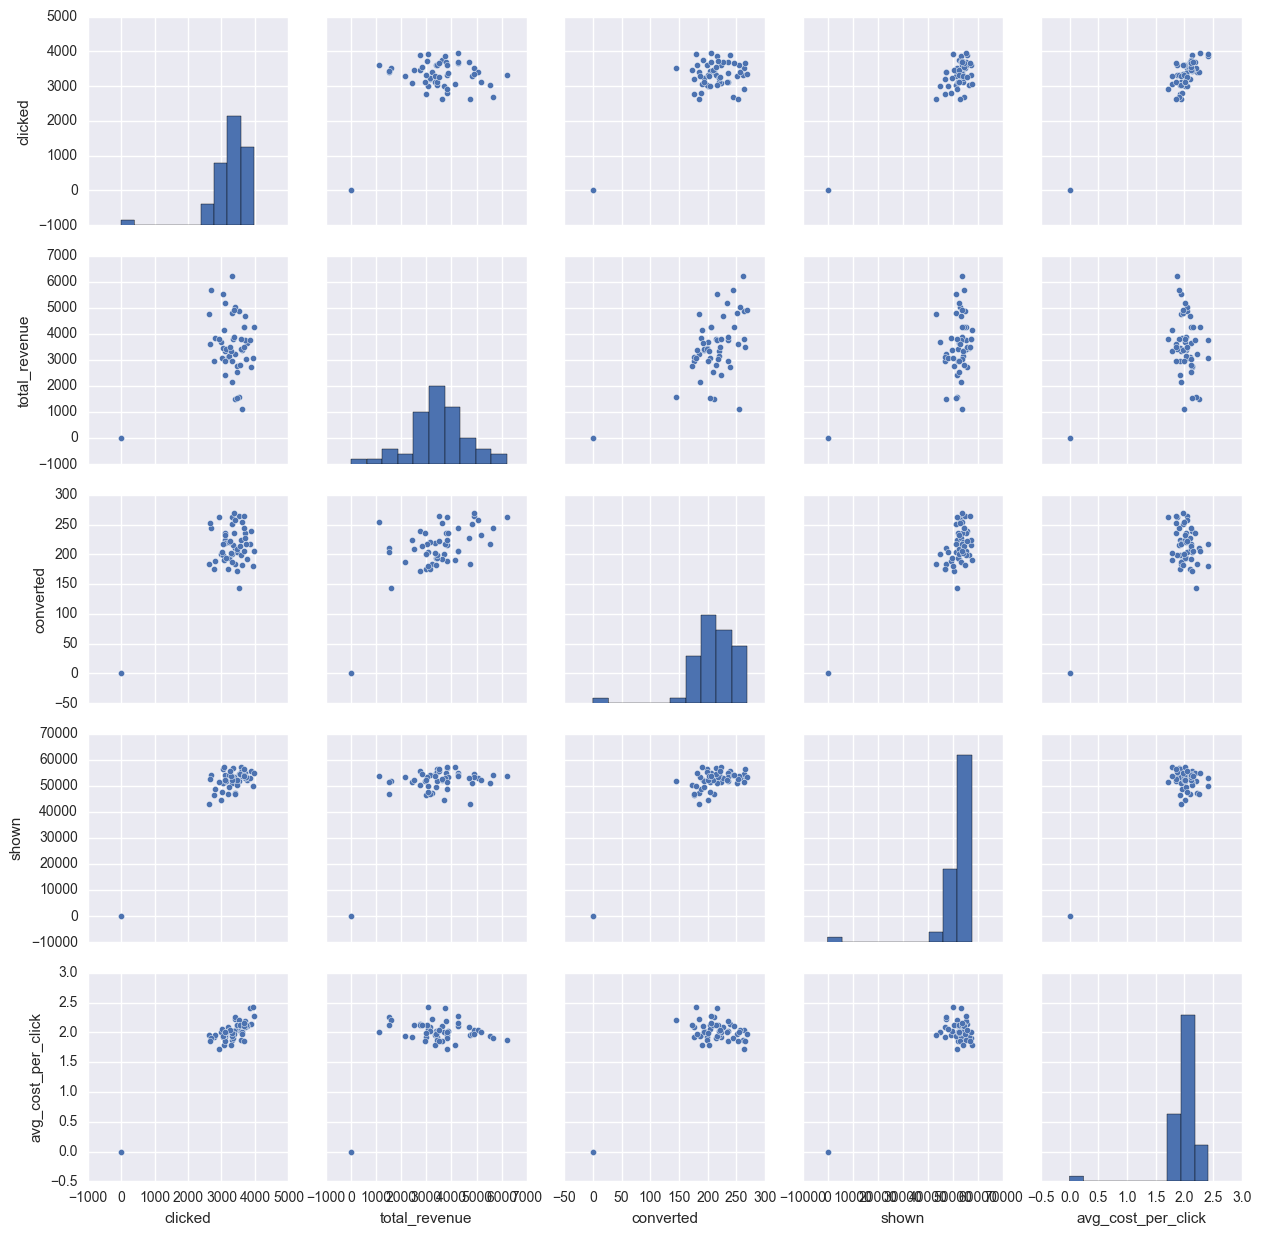

In [32]:
sns.pairplot(df.ix[df['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                              'avg_cost_per_click', 'total_revenue'}])

In the above plot for the ad_group 5 there are few outliers that could totally change the fitting curve or the model. So it is imperative to remove the outliers before proceding to the modeling step.

Again when we look at the plot with all the groups combined then we may not be able to identify these outliers as it could overlap with any other groups data. Therefore I am going to segregate the data based on groups and remove the outliers. 

Check again! Its always better check again than to mistakenly build an incorrect model. 

## Data cleanup - remove outliers:

Find the ratio of outliers, if insignificant just drop them or replace them with appropriate values

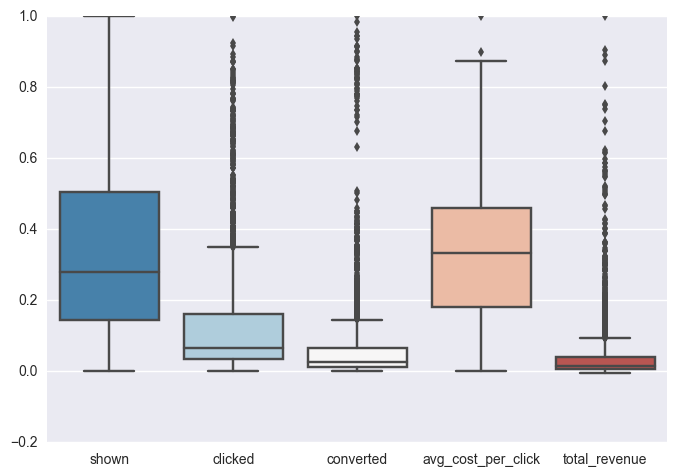

In [45]:
s = df[['shown', 'clicked', 'converted', 'avg_cost_per_click','total_revenue']]
ss = s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

When the data from all the groups are used to find the outliers, we get 100s of data points that are beyond 3 standard deviations (~99.5 percentile limit). When we remove them blindly then we might accidentally drop many useful observations from the data.

Let's check how the outliers look for a particular group, for instance group 5.

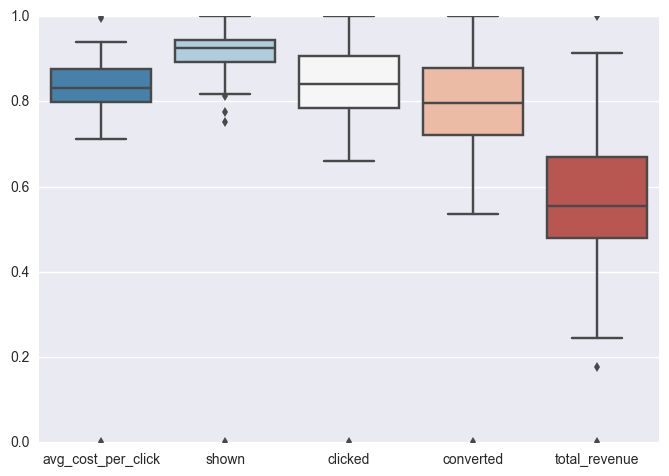

In [40]:
s = df.ix[df['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                     'avg_cost_per_click','total_revenue'}]
ss =  s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

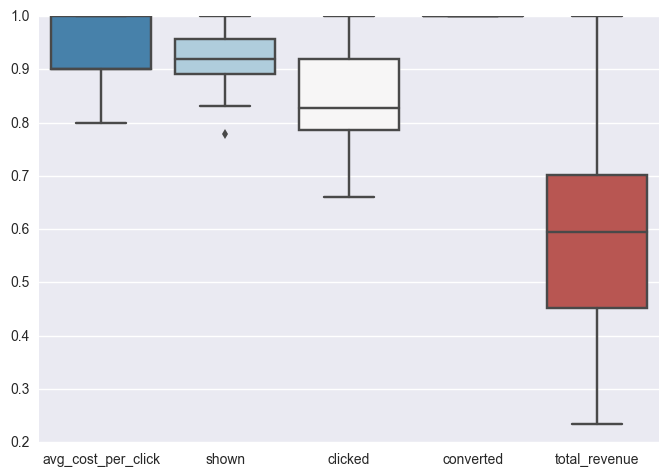

In [84]:
s = df.ix[df['ad'] == 'ad_group_9', {'shown', 'clicked', 'converted', 
                                     'avg_cost_per_click','total_revenue'}]
ss =  s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

In the above plot for the group 5, the outliers are just few and clearly distinct. Most importantly, it makes sense to remove outliers based on each group rather than all groups combined.

### Removing outliers from each column:

In [124]:
dff = df.copy(deep = True)

In [72]:
def remove_outliers(x):
    return x[(np.abs(stats.zscore(x)) < 3).all(axis = 1)]

In [125]:
columns = {'shown', 'clicked', 'converted', 'avg_cost_per_click','total_revenue'}
index_tobe_removed = []
# Implemented the follwing method as we have some columns with std == 0
for grp in dff.ad.unique():
    index_before = dff.ix[dff['ad'] == grp, columns].index.values # Index of each column
    dd_cols_std = dff.ix[(dff['ad'] == grp)].std() # columns to be considered
    dd_cols = list(dd_cols_std[dd_cols_std > 0].index.values) # removed cols with 0 std
    dd = remove_outliers( dff.ix[ (dff['ad'] == grp), dd_cols] )
    
    index_after = dd.index.values
    index_tobe_removed.extend(list(set(index_before) - set(index_after)))
    
print(index_tobe_removed)

# 1. Done this way because df(length = n) == df(length < n) - not possible to replace df of 
# unequal lengths.If it replacing with statistical mean or mode, it could be simply assigned (replaced).
# So select only the indices of the data to be removed.
# 2. std is checked for each column separately and columns with same values is dropped 
# otherwise all the values are assumed to be outside 3 std limit as the std = 0. 
# Then we will endup deleting the entire group

[17, 28, 201, 204, 223, 525, 554, 570, 566, 580, 632, 607, 650, 676, 811, 821, 893, 899, 1000, 1005, 1057, 1091, 1211, 1175, 1215, 1273, 1471, 1556, 1697, 1737, 1744, 1843, 1852, 1928, 2089, 2062]


Dimension before removing outliers:

In [126]:
dff.shape

(2115, 7)

Dimension after removing outliers:

In [127]:
dff.drop(dff.index[index_tobe_removed], inplace = True)
dff.shape

(2079, 7)

<b> Outliers removed!! </b>

Lets verify using scatter or boxplot

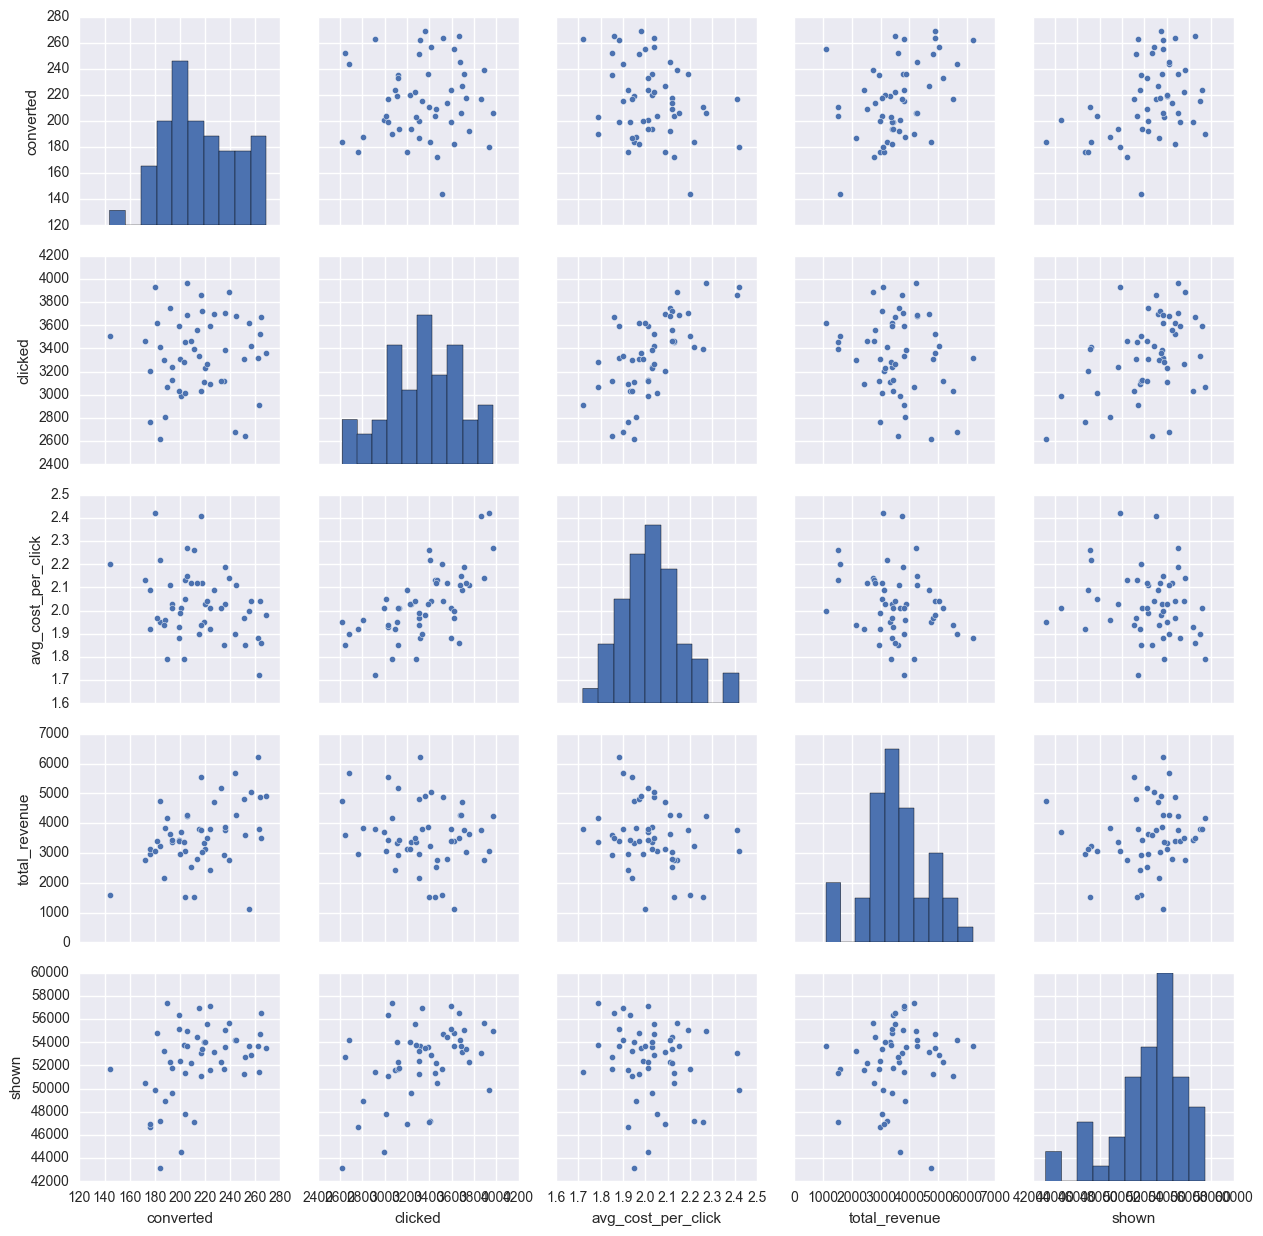

In [10]:
sns.pairplot(dff.ix[dff['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                                'avg_cost_per_click', 'total_revenue'}])

When we compare the above plot for the group 5 with outliers removed and the same plot with outliers not removed, we could easy notice the difference. Now we can clearly see the spread of the data between any 2 parameters and we might be able come up with a reasonably good model.

In [7]:
dff.to_csv("./data/ad_table_cleaned_outliers.csv", index = False)

# Feature Engineering:

In [3]:
dff = pd.read_csv("./data/ad_table_cleaned_outliers.csv")
dff['date'] = pd.to_datetime(dff['date'])
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


Let's add new variables that might be helpful for developing an accurate model

### Adding ratios:

In [4]:
dff['CTR'] = dff['clicked'] / dff['shown']
dff['CR'] = dff['converted'] / dff['clicked']

### Adding info from timestamps:

In [5]:
US_holidays = holidays.US()
dff['business_day'] = [isbday(x, US_holidays) for x in dff['date']]
dff['Week_day'] = [ x.weekday() for x in dff['date']]
# Same as Week_day column but with day names instead of nominal values. Only for exploration.
dff['Week_day_name'] = [calendar.day_name[x] for x in dff['Week_day']]
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,Week_day_name
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,True,3,Thursday
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,True,4,Friday
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,False,5,Saturday
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,False,6,Sunday
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,True,0,Monday


Now we have added new variables,<br>
<b>CTR</b> - Click-through rate<br>
<b>CR</b> - Conversion rate<br>
<b>business_day</b> - working day (1) or holiday (0)<br>
<b>Week_day</b> - Day of the week (0-6 -> Monday to Sunday)<br>
<b>Week_day_name</b> - Name of the weekday

In the following section, let's analyse the importance of these variables and decide whether to retain them in the dataset or drop them

In [6]:
dff.to_csv("./data/ad_table_data_engineering.csv", index = 0)

# Data exploration

In [4]:
dff = pd.read_csv("./data/ad_table_data_engineering.csv")
dff['date'] = pd.to_datetime(dff['date'])
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,Week_day_name
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,True,3,Thursday
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,True,4,Friday
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,False,5,Saturday
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,False,6,Sunday
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,True,0,Monday


Does weekday and holiday category correlates to the target variable??

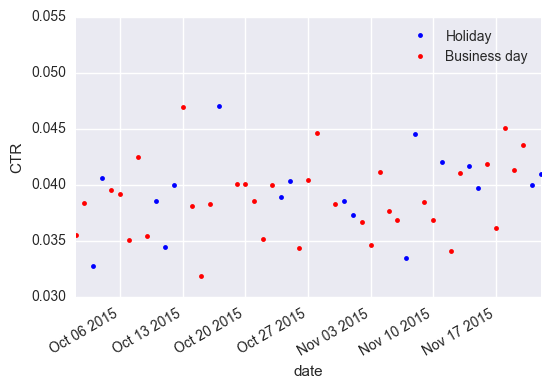

In [5]:
plt.figure()
ax = dff.ix[(dff.ad == 'ad_group_1') & (dff['business_day'] == 0)].plot('date', 'CTR', 
                                                                         style = 'b.', label = "Holiday")
dff.ix[(dff.ad == 'ad_group_1') & (dff['business_day'] == 1)].plot('date', 'CTR', 
                                                                    style = 'r.', ax = ax, 
                                                                    label = "Business day")
ax.set_ylabel("CTR")
ax.set_ylim(0.03, 0.055)
plt.legend()
plt.show()

In [6]:
dff_Week_day_name = pd.DataFrame()
dff_Week_day_name['avg'] = dff.groupby(['ad', 'Week_day_name'])['CTR'].mean()
dff_Week_day_name['std'] = dff.groupby(['ad', 'Week_day_name'])['CTR'].std()
dff_Week_day_name = dff_Week_day_name.reset_index()
dff_Week_day_name.head()

,ad,Week_day_name,avg,std
0,ad_group_1,Friday,0.038979,0.002514
1,ad_group_1,Monday,0.038705,0.002479
2,ad_group_1,Saturday,0.038861,0.004519
3,ad_group_1,Sunday,0.039686,0.003150
4,ad_group_1,Thursday,0.036860,0.003864


In [7]:
dff_Week_day_name['COV'] = dff_Week_day_name['std'] / dff_Week_day_name['avg']

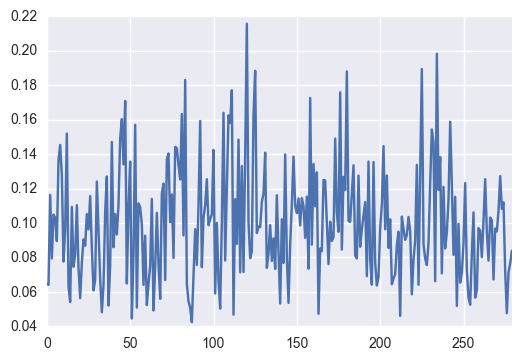

In [8]:
dff_Week_day_name['COV'].plot()

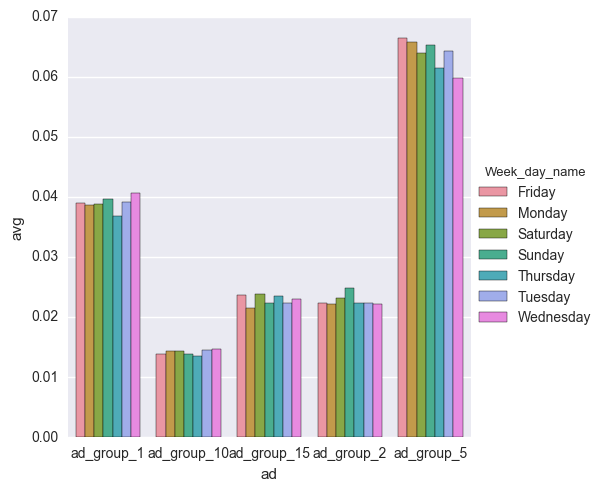

In [9]:
dd = dff_Week_day_name[dff_Week_day_name['ad'].isin(['ad_group_1', 'ad_group_2', 'ad_group_15', 
                                                     'ad_group_5', 'ad_group_10'])]
sns.factorplot(x = 'ad', y = 'avg', hue = 'Week_day_name', data = dd, kind="bar", size = 5)

In [10]:
dff_business_day = dff.groupby(['ad', 'business_day'])['CTR'].mean()
dff_business_day = dff_business_day.reset_index()
dff_business_day.head()

,ad,business_day,CTR
0,ad_group_1,False,0.039450
1,ad_group_1,True,0.038749
2,ad_group_10,False,0.014186
3,ad_group_10,True,0.014115
4,ad_group_11,False,0.064801


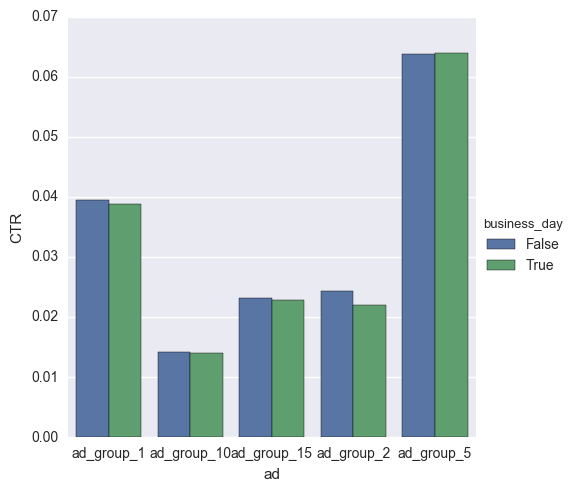

In [11]:
dd = dff_business_day[dff_business_day['ad'].isin(['ad_group_1', 'ad_group_2', 'ad_group_15', 'ad_group_5', 'ad_group_10'])]
sns.factorplot(x = 'ad', y = 'CTR', hue = 'business_day', data = dd, kind="bar", size = 5)

## Quality Factor

Finally lets compute the Quality Factor:

$$QF = \frac{{CTR + CR + CP{C^{ - 1}} + W{S^{ - 1}} + RCPC}}{5}$$

$CTR = \frac{{{\rm{ads\_clicked}}}}{{{\rm{ads\_shown}}}}$ <br>
$CR = \frac{{{\rm{ads\_converted}}}}{{{\rm{ads\_clicked}}}}$ <br>
$CPC = \frac{{{\rm{total\_amount\_spent}}}}{{{\rm{ads\_converted}}}}$ <br>
$WS = {(clicked - converted)} * {avg\_cost\_per\_click} $ <br>
$RCPC = \frac{{{\rm{Total\_revenue}}}}{{{\rm{ads\_clicked}}}}$ <br>

In [12]:
dff.drop(['business_day', 'Week_day', 'Week_day_name'], axis = 1, inplace = True)

In [13]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208


In [14]:
money_spent = dff['avg_cost_per_click'] * dff['clicked']

dff['CPC'] = money_spent / dff['converted']
dff['WS'] = (dff['clicked'] - dff['converted']) * dff['avg_cost_per_click']
dff['RCPC'] = dff['total_revenue'] / dff['clicked']

In [15]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,CPC,WS,RCPC
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,48.955814,2066.40,0.274314
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,61.792632,2312.40,0.302790
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,40.595510,1947.04,0.419758
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,56.104510,2809.82,0.320293
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,65.756098,2655.00,0.326205


$$QF = \frac{{CTR + CR + CP{C^{ - 1}} + W{S^{ - 1}} + RCPC}}{5}$$

In [16]:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC - min: %.3f, max: %.3f" %(dff.CPC.min(), dff.CPC.max()))
print("WS - min: %.3f, max: %.3f" %(dff.WS.min(), dff.WS.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.124
CR - min: 0.000, max: 0.145
CPC - min: 1.034, max: inf
WS - min: 17.360, max: 66710.220
RCPC - min: -0.105, max: 2.900


In [48]:
np.percentile(dff.CPC, 97)

1786.0251999999987

In [57]:
np.percentile(dff.CPC, 95)

934.88208333333182

In [53]:
np.percentile(dff.WS, 97)

25714.203599999975

In [58]:
np.percentile(dff.WS, 95)

21121.325999999994

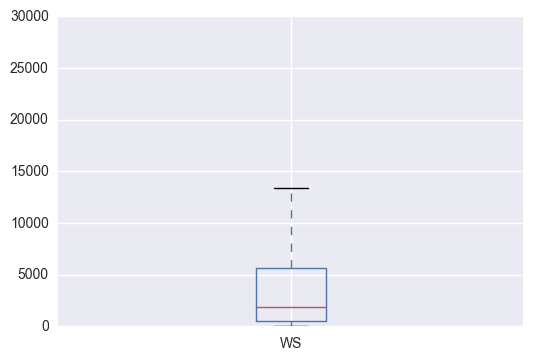

In [54]:
dff.ix[dff['WS'] < 25714, 'WS'].plot.box()

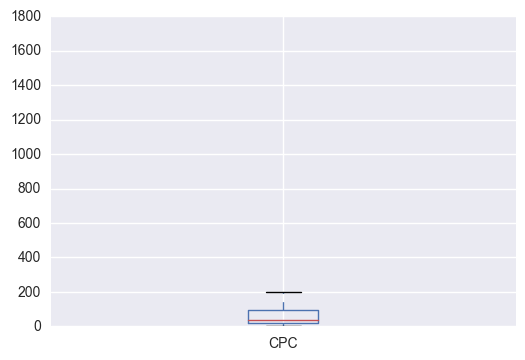

In [49]:
dff.ix[dff['CPC'] < 1786, 'CPC'].plot.box()

In [24]:
dff.shape

(2079, 12)

In [65]:
dff[(dff['WS'] < 1000000) & (dff['CPC'] < 1000000)].shape

(2027, 12)

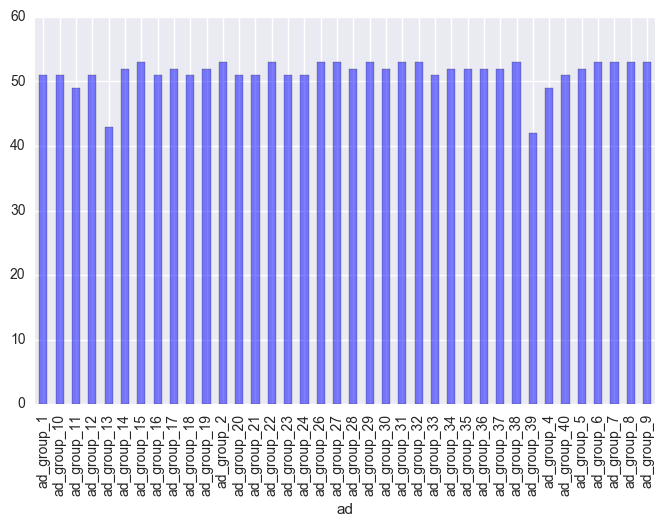

In [56]:
dfff = dff[(dff['WS'] < 25714) & (dff['CPC'] < 1786)].groupby('ad')['shown'].count()
dfff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

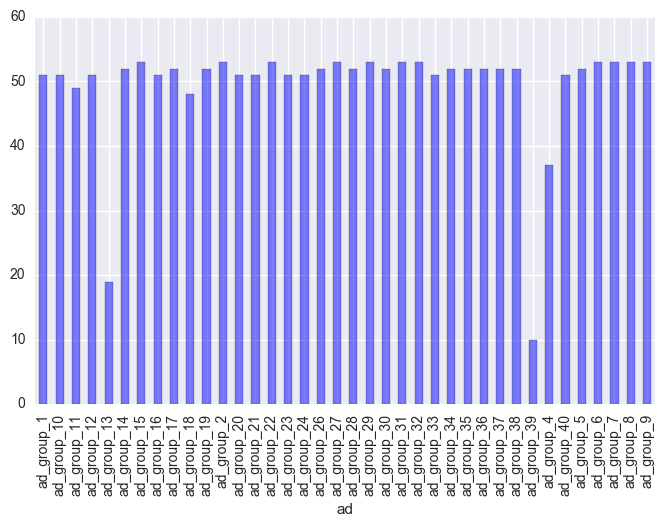

In [59]:
dfff = dff[(dff['WS'] < 21121) & (dff['CPC'] < 934)].groupby('ad')['shown'].count()
dfff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

Group_39 - High CPC <br>
Group_13 - High WS <br>
So lets drop them

In [72]:
drop_list_ad_group = ['ad_group_13', 'ad_group_39']
dff[ ~dff['ad'].isin(drop_list_ad_group) ].ad.unique()

array(['ad_group_1', 'ad_group_2', 'ad_group_3', 'ad_group_4',
       'ad_group_5', 'ad_group_6', 'ad_group_7', 'ad_group_8',
       'ad_group_9', 'ad_group_10', 'ad_group_11', 'ad_group_12',
       'ad_group_14', 'ad_group_15', 'ad_group_16', 'ad_group_17',
       'ad_group_18', 'ad_group_19', 'ad_group_20', 'ad_group_21',
       'ad_group_22', 'ad_group_23', 'ad_group_24', 'ad_group_26',
       'ad_group_27', 'ad_group_28', 'ad_group_29', 'ad_group_30',
       'ad_group_31', 'ad_group_32', 'ad_group_33', 'ad_group_34',
       'ad_group_35', 'ad_group_36', 'ad_group_37', 'ad_group_38',
       'ad_group_40'], dtype=object)

In [73]:
dff = dff[ ~dff['ad'].isin(drop_list_ad_group) ].reset_index(drop = True)

In [74]:
dff.shape

(1923, 12)

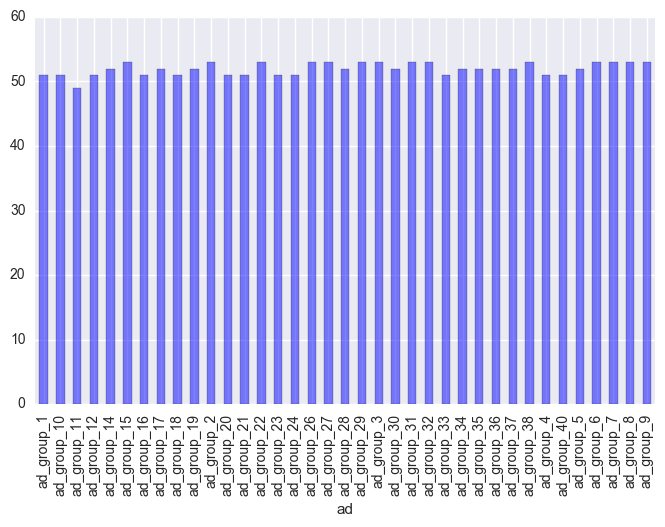

In [75]:
dfff = dff.groupby('ad')['shown'].count()
dfff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

In [76]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC - min: %.3f, max: %.3f" %(dff.CPC.min(), dff.CPC.max()))
print("WS - min: %.3f, max: %.3f" %(dff.WS.min(), dff.WS.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.124
CR - min: 0.001, max: 0.145
CPC - min: 1.034, max: 1180.504
WS - min: 17.360, max: 66710.220
RCPC - min: -0.105, max: 2.868


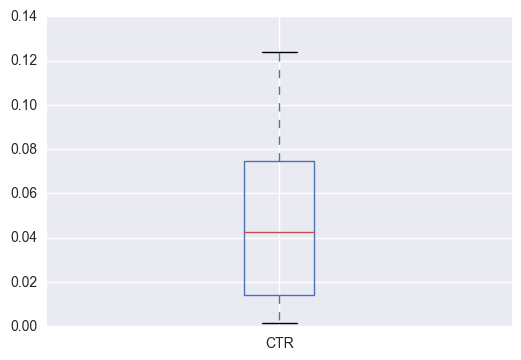

In [79]:
dff[['CTR']].plot.box()

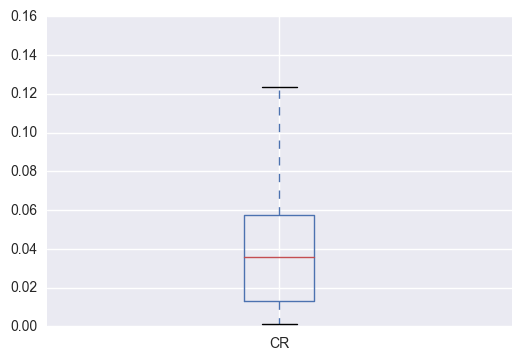

In [80]:
dff[['CR']].plot.box()

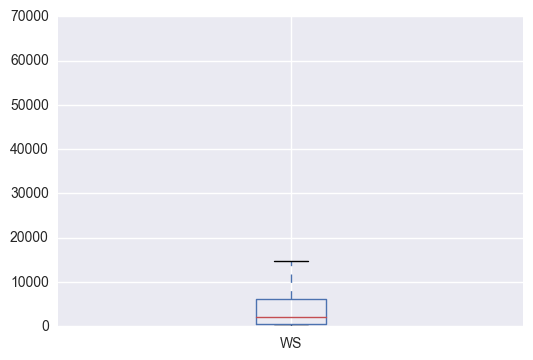

In [81]:
dff[['WS']].plot.box()

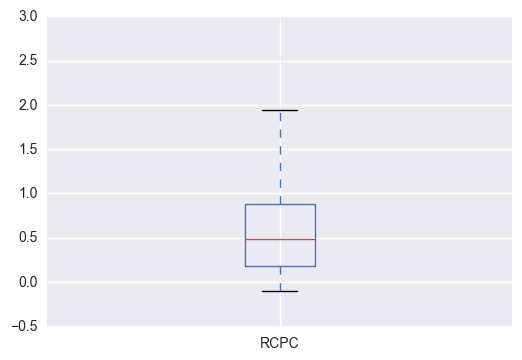

In [82]:
dff[['RCPC']].plot.box()

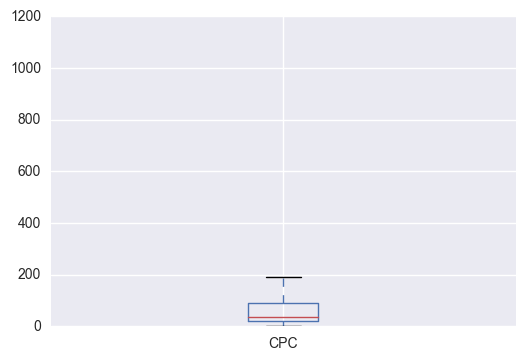

In [83]:
dff[['CPC']].plot.box()

We have lot of outliers in WS and CPC. Lets find mean WS and CPC for each group and drop groups with high mean

In [95]:
aff = dff.groupby('ad')['WS'].mean()
bff = dff.groupby('ad')['CPC'].mean()

In [94]:
aff.sort_values(ascending = False).head(10)

ad
ad_group_3     43370.961698
ad_group_4     18841.019412
ad_group_18    16600.690392
ad_group_38    15268.214340
ad_group_26    14089.320000
ad_group_20    13138.984118
ad_group_37    10728.972115
ad_group_7      8865.924340
ad_group_32     6588.757925
ad_group_5      6372.208462
Name: WS, dtype: float64

In [96]:
bff.sort_values(ascending = False).head(10)

ad
ad_group_3     756.691659
ad_group_7     360.033043
ad_group_24    329.302925
ad_group_32    252.578300
ad_group_38    198.540031
ad_group_35    193.631154
ad_group_29    111.123743
ad_group_10    102.011993
ad_group_6      93.020708
ad_group_19     87.362560
Name: CPC, dtype: float64

## Justify this
ad_group_3 - has high WS and high CPC <br>
ad_group_38 - has high WS and high CPC <br>
ad_group_4 - high WS <br>
ad_group_18 - high WS <br>

Lets drop all the groups

In [97]:
drop_list_ad_group = ['ad_group_3', 'ad_group_38', 'ad_group_4', 'ad_group_18']
dff[ ~dff['ad'].isin(drop_list_ad_group) ].ad.unique()

array(['ad_group_1', 'ad_group_2', 'ad_group_5', 'ad_group_6',
       'ad_group_7', 'ad_group_8', 'ad_group_9', 'ad_group_10',
       'ad_group_11', 'ad_group_12', 'ad_group_14', 'ad_group_15',
       'ad_group_16', 'ad_group_17', 'ad_group_19', 'ad_group_20',
       'ad_group_21', 'ad_group_22', 'ad_group_23', 'ad_group_24',
       'ad_group_26', 'ad_group_27', 'ad_group_28', 'ad_group_29',
       'ad_group_30', 'ad_group_31', 'ad_group_32', 'ad_group_33',
       'ad_group_34', 'ad_group_35', 'ad_group_36', 'ad_group_37',
       'ad_group_40'], dtype=object)

In [102]:
dff = dff[ ~dff['ad'].isin(drop_list_ad_group) ].reset_index(drop = True)

In [103]:
dff.shape

(1715, 12)

In [104]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC - min: %.3f, max: %.3f" %(dff.CPC.min(), dff.CPC.max()))
print("WS - min: %.3f, max: %.3f" %(dff.WS.min(), dff.WS.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.113
CR - min: 0.001, max: 0.145
CPC - min: 1.034, max: 565.544
WS - min: 17.360, max: 22291.800
RCPC - min: -0.105, max: 2.868


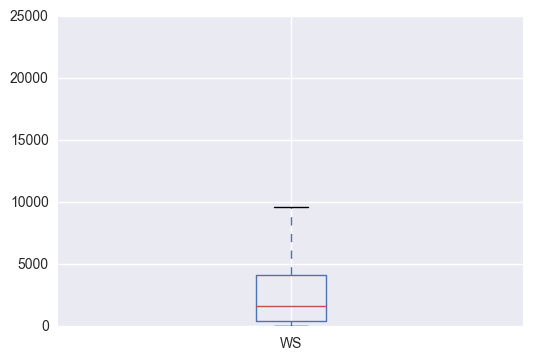

In [105]:
dff[['WS']].plot.box()

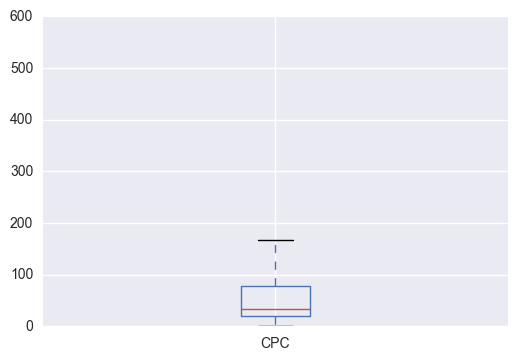

In [106]:
dff[['CPC']].plot.box()

Now that we removed the outliers. Lets go ahead and apply normalization technique to the metric.

In [107]:
dff.to_csv("./data/ad_table_data_engineering_outlier.csv", index = 0)

# Normalization of the metrics

In [3]:
dff = pd.read_csv("./data/ad_table_data_engineering_outlier.csv")
dff['date'] = pd.to_datetime(dff['date'])
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,CPC,WS,RCPC
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,48.955814,2066.40,0.274314
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,61.792632,2312.40,0.302790
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,40.595510,1947.04,0.419758
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,56.104510,2809.82,0.320293
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,65.756098,2655.00,0.326205


In [4]:
dff['CPC_1'] = 1/dff['CPC']
dff['WS_1'] = 1/dff['WS']

In [5]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC_1 - min: %.3f, max: %.3f" %(dff.CPC_1.min(), dff.CPC_1.max()))
print("WS_1 - min: %.3f, max: %.3f" %(dff.WS_1.min(), dff.WS_1.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.113
CR - min: 0.001, max: 0.145
CPC_1 - min: 0.002, max: 0.967
WS_1 - min: 0.000, max: 0.058
RCPC - min: -0.105, max: 2.868


We want all 5 to be on the same scale so that all carries the same weight when used on computing the QF. This can be achieved by applying minmax scaler from sklearn module on each of these metrics

In [6]:
# Why RCPC is negative:
dff[dff['RCPC'] < 0]

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,CPC,WS,RCPC,CPC_1,WS_1
957,2015-10-25,50459,1904,97,0.89,-200.15,ad_group_23,0.037734,0.050945,17.469691,1608.23,-0.105121,0.057242,0.000622
1120,2015-11-01,70145,584,15,0.36,-25.09,ad_group_27,0.008326,0.025685,14.016000,204.84,-0.042962,0.071347,0.004882
1239,2015-11-15,22070,1400,20,1.67,-3.56,ad_group_29,0.063435,0.014286,116.900000,2304.60,-0.002543,0.008554,0.000434


In [15]:
mm_scaler_CTR = MM()
mm_scaler_CR = MM()
mm_scaler_CPC_1 = MM()
mm_scaler_WS_1 = MM()
mm_scaler_RCPC = MM()

In [17]:
dff['CTR'] = mm_scaler_CTR.fit_transform(dff['CTR'])
dff['CR'] = mm_scaler_CR.fit_transform(dff['CR'])
dff['CPC_1'] = mm_scaler_CPC_1.fit_transform(dff['CPC_1'])
dff['WS_1'] = mm_scaler_WS_1.fit_transform(dff['WS_1'])
dff['RCPC'] = mm_scaler_RCPC.fit_transform(dff['RCPC'])

In [18]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff['CTR'].min(), dff['CTR'].max()))
print("CR - min: %.3f, max: %.3f" %(dff['CR'].min(), dff['CR'].max()))
print("CPC - min: %.3f, max: %.3f" %(dff['CPC_1'].min(), dff['CPC_1'].max()))
print("WS - min: %.3f, max: %.3f" %(dff['WS_1'].min(), dff['WS_1'].max()))
print("RCPC - min: %.3f, max: %.3f" %(dff['RCPC'].min(), dff['RCPC'].max()))

CTR - min: 0.000, max: 1.000
CR - min: 0.000, max: 1.000
CPC - min: 0.000, max: 1.000
WS - min: 0.000, max: 1.000
RCPC - min: 0.000, max: 1.000


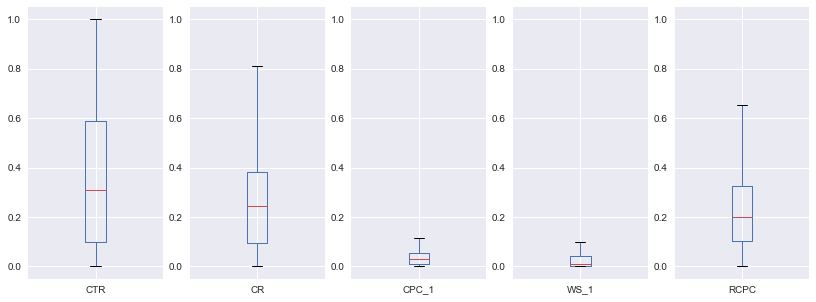

In [19]:
plts, ax = plt.subplots(1, 5, figsize = (14, 5))
dff['CTR'].plot.box(ax = ax[0])
dff['CR'].plot.box(ax = ax[1])
dff['CPC_1'].plot.box(ax = ax[2])
dff['WS_1'].plot.box(ax = ax[3])
dff['RCPC'].plot.box(ax = ax[4])

In [20]:
dff.to_excel("./data/data_engineering_outlier_normalized.xlsx")

--------------------------------------------------------------------------------------------------------------

### Compute Quality factor:

In [21]:
dff['QF'] = dff[['CTR','CR', 'RCPC', 'CPC_1', 'WS_1']].mean(axis = 1)

In [22]:
dff[['CTR', 'CR', 'CPC', 'WS', 'RCPC', 'QF']].head(10)

,CTR,CR,CPC,WS,RCPC,QF
0,0.304341,0.121223,48.955814,2066.40,0.127626,0.116030
1,0.330098,0.099130,61.792632,2312.40,0.137204,0.117621
2,0.279443,0.140731,40.595510,1947.04,0.176547,0.125712
3,0.349963,0.118564,56.104510,2809.82,0.143091,0.126732
4,0.340587,0.099099,65.756098,2655.00,0.145080,0.120892
5,0.336995,0.115605,55.753478,2519.58,0.131302,0.121354
6,0.300068,0.115576,53.490476,2207.12,0.100425,0.108140
7,0.366792,0.103315,67.665870,3063.41,0.086382,0.114973
8,0.303973,0.136276,42.832653,2055.68,0.120278,0.118112
9,0.331369,0.105087,57.881429,2391.96,0.098480,0.111498


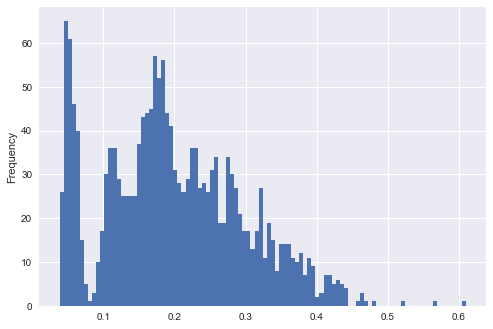

In [23]:
dff['QF'].plot.hist(bins = 100)

<b> Higher the Quality Factor better is the performance

In [24]:
ranks = dff.groupby('ad')['QF'].mean()
ranks = ranks.reset_index().set_index('ad', drop = True)

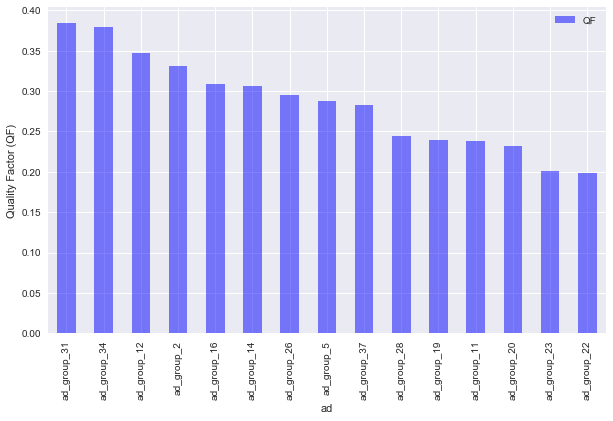

In [28]:
ax = ranks.sort('QF', ascending = False)[:15].plot.bar(color = 'b', alpha = 0.5, figsize = (10, 6))
ax.set_ylabel("Quality Factor (QF)")

In [54]:
ranks.sort('QF', ascending = False)[:5].index.values.tolist() # Ranked in order

['ad_group_13', 'ad_group_34', 'ad_group_18', 'ad_group_2', 'ad_group_16']

From the above bar chart, it is evident that the top 5 best performing Ad campaigns are 
1. ad_group_13
2. ad_group_34
3. ad_group_12
4. ad_group_2
5. ad_group_16

In [45]:
dff.to_excel("./data/ad_table_cleaned_QF.xlsx", index = False)

<b> <font, color = 'red'> Add summary 

----------------------------------------------------------------------------------------------------

# 2. Prediction

Question: For each group predict, <b> how many ads will be shown on a particular date </b> (let's say Dec 15) by assuming that each group follows its trend.

In [44]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,CPC,WS,RCPC,CPC_1,WS_1,QF
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.304341,0.121223,48.955814,2066.40,0.127626,0.019335,0.007628,0.116030
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.330098,0.099130,61.792632,2312.40,0.137204,0.014937,0.006734,0.117621
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.279443,0.140731,40.595510,1947.04,0.176547,0.023694,0.008144,0.125712
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.349963,0.118564,56.104510,2809.82,0.143091,0.016638,0.005404,0.126732
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.340587,0.099099,65.756098,2655.00,0.145080,0.013927,0.005764,0.120892


For predictive analysis, we do not need QF and other parameters that involve simple mathematical operations such as multiplication, division, etc. This would lead to a well-known problem called multicollinearity. To avoid that we can simple remove the respective columns.

In [63]:
df_prediction = dff.copy( deep = True )

Before removing the columns blindly, lets check for multicollinearity using correlation matrix:

In [47]:
df_prediction.columns

Index(['date', 'shown', 'clicked', 'converted', 'avg_cost_per_click',
       'total_revenue', 'ad', 'CTR', 'CR', 'CPC', 'WS', 'RCPC', 'CPC_1',
       'WS_1', 'QF'],
      dtype='object')

## Parameter selection:

In [33]:
corr_matrix = df_prediction.corr()
print(corr_matrix)

                       shown   clicked  converted  avg_cost_per_click  \
shown               1.000000  0.219114   0.129951           -0.338655   
clicked             0.219114  1.000000   0.797709            0.508735   
converted           0.129951  0.797709   1.000000            0.392698   
avg_cost_per_click -0.338655  0.508735   0.392698            1.000000   
total_revenue       0.122164  0.746222   0.930655            0.372314   
CTR                -0.385915  0.679758   0.521742            0.693904   
CR                 -0.220362 -0.011596   0.456612           -0.111833   
CPC                -0.070915  0.177550  -0.248019            0.466479   
WS                  0.120701  0.973893   0.772518            0.611655   
RCPC               -0.190402  0.010830   0.420590           -0.077849   
CPC_1               0.248646 -0.230289  -0.019807           -0.436635   
WS_1                0.336837 -0.294908  -0.221764           -0.460484   
QF                 -0.225946  0.245355   0.564958  

In [52]:
filtered_cols = ['shown', 'clicked', 'converted', 'avg_cost_per_click', 'total_revenue']
matrix = corr_matrix.ix[filtered_cols][filtered_cols]

<b> Correlation Matrix (Heat Map) - Based on Pearson's correlation coefficients:

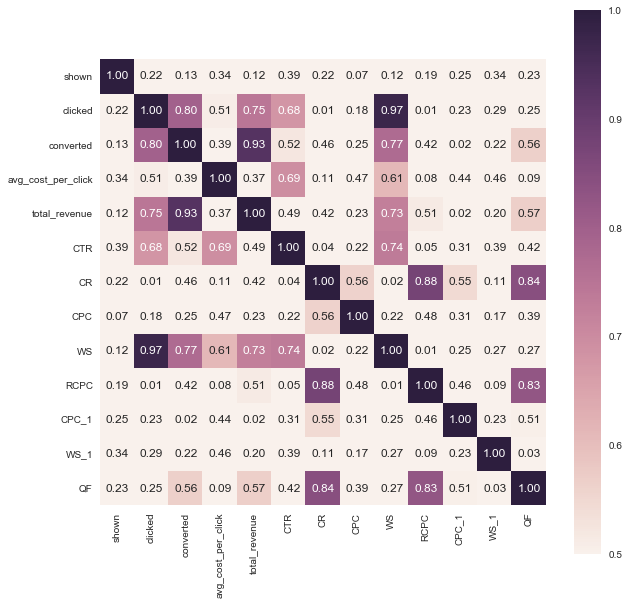

In [56]:
plt.figure(figsize=(10, 10))
sns.heatmap(abs(corr_matrix), vmax = 1, vmin = 0.5,
            square = True, annot=True, fmt=".2f")

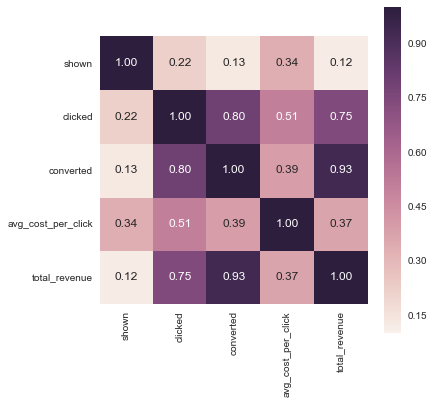

In [55]:
plt.figure(figsize=(6, 6))
sns.heatmap(abs(matrix), vmax = 1, vmin = 0.1,
            square = True, annot=True, fmt=".2f")

In [64]:
df_prediction = df_prediction[filtered_cols + ['date', 'ad']]
df_prediction.head()

,shown,clicked,converted,avg_cost_per_click,total_revenue,date,ad
0,65877,2339,43,0.90,641.62,2015-10-01,ad_group_1
1,65100,2498,38,0.94,756.37,2015-10-02,ad_group_1
2,70658,2313,49,0.86,970.90,2015-10-03,ad_group_1
3,69809,2833,51,1.01,907.39,2015-10-04,ad_group_1
4,68186,2696,41,1.00,879.45,2015-10-05,ad_group_1


In [65]:
df_prediction = df_prediction.set_index('date', drop = True)

In [66]:
df_prediction.head()

,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
date,,,,,,
2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


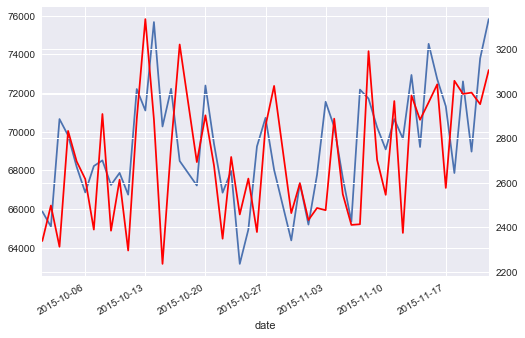

In [72]:
ax = df_prediction.ix[df_prediction.ad == 'ad_group_1', 'shown'].plot()
ax2 = ax.twinx()
df_prediction.ix[df_prediction.ad == 'ad_group_1', 'clicked'].plot(ax = ax2, color = 'red')

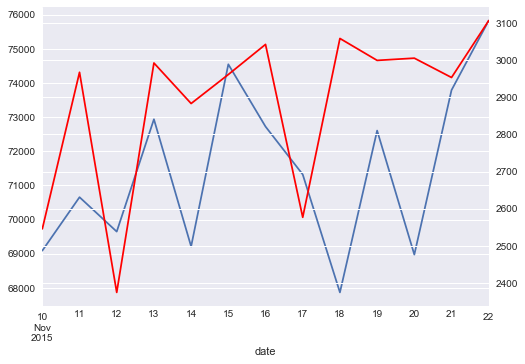

In [74]:
ax = df_prediction[df_prediction.ad == 'ad_group_1'].ix['2015-11-10':, 'shown'].plot()
ax2 = ax.twinx()
df_prediction[df_prediction.ad == 'ad_group_1'].ix['2015-11-10':, 'clicked'].plot(ax = ax2, color = 'red')

### Applying cross-correlation:

In [76]:
from scipy.signal import correlate as crosscorr

In [77]:
df1 = df_prediction.ix[df_prediction.ad == 'ad_group_1', 'shown'].values
df2 = df_prediction.ix[df_prediction.ad == 'ad_group_1', 'clicked'].values

In [80]:
a = crosscorr(df1, df2, mode = 'same')
a = a/a.max()

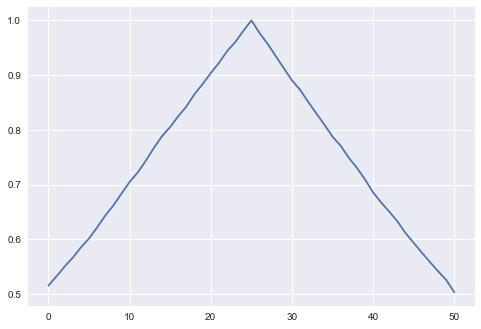

In [82]:
plt.plot(a)

So there is no cross-correlation between shown and clicked

In [83]:
df_prediction.head()

,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
date,,,,,,
2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [92]:
# Add more information to the data
df_prediction['day'] = df_prediction.index.map(lambda x: x.weeday)

In [97]:
df_prediction['business_day'] = [isbday(x, US_holidays) for x in df_prediction.index]
df_prediction['Week_day'] = [ x.weekday() for x in df_prediction.index]

In [98]:
df_prediction.head()

,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,day,business_day,Week_day
date,,,,,,,,,
2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,1,True,3
2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,2,True,4
2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,3,False,5
2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,4,False,6
2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,5,True,0


In [99]:
df_prediction.tail()

,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,day,business_day,Week_day
date,,,,,,,,,
2015-11-18,78111,1326,37,1.01,553.36,ad_group_40,18,True,2
2015-11-19,79857,1413,34,1.00,840.72,ad_group_40,19,True,3
2015-11-20,75695,1332,35,1.09,468.95,ad_group_40,20,True,4
2015-11-21,73761,1336,36,1.11,437.03,ad_group_40,21,False,5
2015-11-22,77907,1391,34,0.99,409.30,ad_group_40,22,False,6


For time-series forecasting, the only parameter that will be available for forecasting is the date.

In [101]:
df_prediction = df_prediction[['shown']]

From the plot of the time-series data for 'shown' it is clear that there is no periodic trend (or seasonality) in the data. However lets apply <b> 'Augmented Dickey-Fuller test' </b> to check if the data is stationary

In [100]:
from statsmodels.tsa.stattools import adfuller

In [103]:
result = adfuller(df_prediction.shown.values)

In [104]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.870262
p-value: 0.002265
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


As the p-value is < 0.05 the null hypothesis is rejected which is that the time-series data is non-stationary. Now we have proved that the data stationary and we can pick models accordingly.

## ARMA Model:

#### ACF and PACF plots:
To identify input parameters for the ARMA model

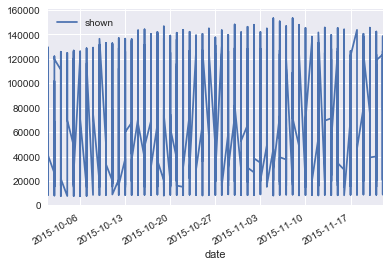

In [106]:
df_prediction.plot()

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5)<br>
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value<br>
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

In [181]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.api import tsa

In [162]:
lag_acf = acf(df_prediction, nlags=60)
lag_pacf = pacf(df_prediction, nlags=20, method='ols')

In [134]:
from matplotlib import lines
lines.lineStyles.keys()

dict_keys(['-', '--', '-.', ':', 'None', ' ', ''])

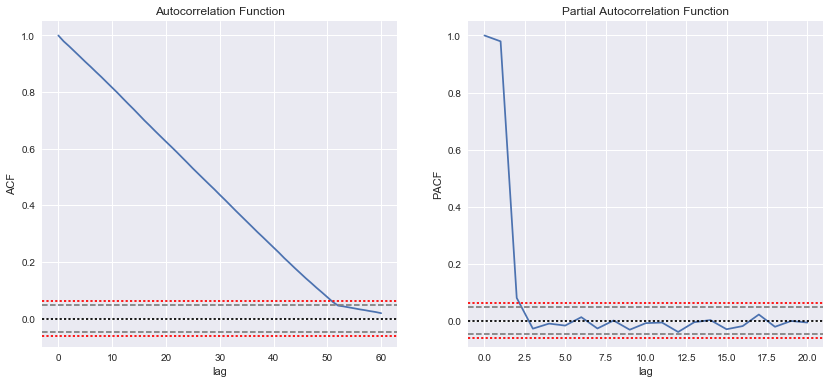

In [170]:
figs, ax = plt.subplots(1, 2, figsize = (14, 6))
ax[0].plot(lag_acf)
ax[0].axhline(y=0,linestyle=':',color='black')
ax[0].axhline(y=-1.96/np.sqrt(len(df_prediction)),linestyle='--',color='gray')
ax[0].axhline(y=1.96/np.sqrt(len(df_prediction)),linestyle='--',color='gray')
ax[0].axhline(y=-2.576/np.sqrt(len(df_prediction)),linestyle=':',color='red')
ax[0].axhline(y=2.576/np.sqrt(len(df_prediction)),linestyle=':',color='red')
ax[0].set_title('Autocorrelation Function')
ax[0].set_ylabel('ACF')
ax[0].set_xlabel('lag')

ax[1].plot(lag_pacf)
ax[1].axhline(y=0,linestyle=':',color='black')
ax[1].axhline(y=-1.96/np.sqrt(len(df_prediction)),linestyle='--',color='gray')
ax[1].axhline(y=1.96/np.sqrt(len(df_prediction)),linestyle='--',color='gray')
ax[1].axhline(y=-2.576/np.sqrt(len(df_prediction)),linestyle=':',color='red')
ax[1].axhline(y=2.576/np.sqrt(len(df_prediction)),linestyle=':',color='red')
ax[1].set_title('Partial Autocorrelation Function')
ax[1].set_ylabel('PACF')
ax[1].set_xlabel('lag')
plt.show()

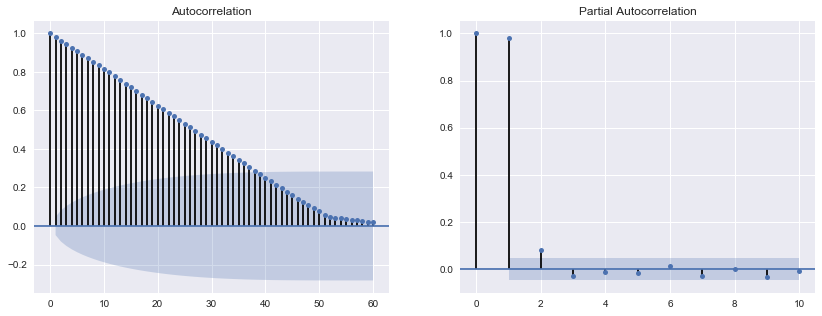

In [179]:
figs, axes = plt.subplots(1, 2, figsize = (14, 5))
plot_acf(df_prediction, lags = 60, ax = axes[0])
plot_pacf(df_prediction, lags = 10, ax = axes[1])
plt.show()

The significance of the PACF at lag = 1 indicates that an autoregressive model may be appropriate

ACF - to identify q-value(MA part)
PACF - to identify p-value(AR part)

p-value = 2
q-value = 39

In [180]:
lag_acf

array([ 1.        ,  0.97915166,  0.96204434,  0.94378847,  0.92562817,
        0.907144  ,  0.88960621,  0.87118252,  0.85335062,  0.83447725,
        0.81585786,  0.79730797,  0.77755007,  0.7581994 ,  0.73934822,
        0.71965015,  0.69979045,  0.68131646,  0.66214507,  0.64356177,
        0.62502164,  0.60686314,  0.588254  ,  0.56902007,  0.54993181,
        0.53034106,  0.51179266,  0.49320237,  0.47469079,  0.45652844,
        0.43733013,  0.41880191,  0.39966151,  0.3803999 ,  0.36183556,
        0.34315978,  0.32450692,  0.3056341 ,  0.28779805,  0.26937072,
        0.251115  ,  0.23289973,  0.21352118,  0.1957494 ,  0.17751911,
        0.16002494,  0.14232962,  0.12574888,  0.10861211,  0.09241733,
        0.07564896,  0.05886522,  0.04581915,  0.04303811,  0.03952671,
        0.03616054,  0.03259129,  0.02961081,  0.02614416,  0.02306336,
        0.01905778])

In [198]:
ARMA_model = tsa.ARMA(df_prediction, order = (2, 20))

In [199]:
ARMA_residuals = ARMA_model.fit(trend='nc')

In [ ]:
ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [201]:
ARMA_residuals.cov_params()

,ar.L1.shown,ar.L2.shown,ma.L1.shown,ma.L2.shown,ma.L3.shown,ma.L4.shown,ma.L5.shown,ma.L6.shown,ma.L7.shown,ma.L8.shown,...,ma.L11.shown,ma.L12.shown,ma.L13.shown,ma.L14.shown,ma.L15.shown,ma.L16.shown,ma.L17.shown,ma.L18.shown,ma.L19.shown,ma.L20.shown
ar.L1.shown,1.034124,-1.027742,-1.033621,0.084866,-0.030348,-0.000357,-0.009782,0.018314,-0.025842,0.012062,...,-0.004122,-0.031797,0.008745,6.953640e-03,-0.025827,-0.002878,0.029773,-0.019677,0.013583,-3.237208e-03
ar.L2.shown,-1.027742,1.021412,1.027241,-0.084356,0.030149,0.000342,0.009709,-0.018214,0.025671,-0.012001,...,0.004085,0.031589,-0.008703,-6.922428e-03,0.025656,0.002848,-0.029601,0.019544,-0.013510,3.207751e-03
ma.L1.shown,-1.033621,1.027241,1.033700,-0.084718,0.030338,0.000362,0.009782,-0.018314,0.025841,-0.012060,...,0.004122,0.031800,-0.008742,-6.955644e-03,0.025828,0.002881,-0.029775,0.019674,-0.013582,3.227014e-03
ma.L2.shown,0.084866,-0.084356,-0.084718,0.007582,-0.002371,-0.000011,-0.000786,0.001518,-0.002116,0.001012,...,-0.000324,-0.002594,0.000746,5.798812e-04,-0.002110,-0.000212,0.002455,-0.001619,0.001118,-2.932880e-04
ma.L3.shown,-0.030348,0.030149,0.030338,-0.002371,0.001506,0.000129,0.000303,-0.000522,0.000772,-0.000351,...,0.000145,0.000946,-0.000241,-1.762302e-04,0.000766,0.000092,-0.000852,0.000574,-0.000434,1.033693e-04
ma.L4.shown,-0.000357,0.000342,0.000362,-0.000011,0.000129,0.000614,0.000122,0.000010,0.000023,0.000010,...,0.000013,0.000035,0.000010,1.260032e-05,0.000036,0.000007,-0.000017,-0.000002,-0.000004,-2.242687e-05
ma.L5.shown,-0.009782,0.009709,0.009782,-0.000786,0.000303,0.000122,0.000707,-0.000055,0.000261,-0.000100,...,0.000059,0.000314,-0.000056,-5.283865e-05,0.000258,0.000042,-0.000305,0.000182,-0.000119,5.590503e-05
ma.L6.shown,0.018314,-0.018214,-0.018314,0.001518,-0.000522,0.000010,-0.000055,0.000940,-0.000341,0.000231,...,-0.000067,-0.000543,0.000168,1.478182e-04,-0.000458,-0.000067,0.000546,-0.000355,0.000261,-2.702350e-05
ma.L7.shown,-0.025842,0.025671,0.025841,-0.002116,0.000772,0.000023,0.000261,-0.000341,0.001259,-0.000183,...,0.000116,0.000799,-0.000201,-1.748583e-04,0.000638,0.000074,-0.000742,0.000533,-0.000324,8.303742e-05
ma.L8.shown,0.012062,-0.012001,-0.012060,0.001012,-0.000351,0.000010,-0.000100,0.000231,-0.000183,0.000754,...,-0.000035,-0.000360,0.000095,6.824717e-05,-0.000299,-0.000020,0.000375,-0.000207,0.000188,-2.106932e-05
